## June 29 2016 
Notes on the effect of the BEC meanfield on the momentum distribution of excitations.  Here I'll simulate the $classical$ trajectory a particle takes during TOF in the presence of an expanding BEC.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# constants
hbar=1.054e-34
m=4e-3/6.02e23
a=7.5e-9
g=4*np.pi*hbar**2*a/m;

Setup initial BEC parameters - peak BEC density, TF radius, trap frequency

In [3]:
n0=1e19
RTF0=10e-6
omega=2*np.pi*400

In [4]:
# initial k-vectors
kList=np.arange(0.5,10.5,0.5)*1e6
dk=kList[1]-kList[0]
Nk=len(kList)

Pre-calculate the time-dynamics of the expanding BEC.  Assume the a Thomas-Fermi distirbution, and the scaling solution.  In this case, the only thing we need to know is how the condensate size changes with time, RTF(t).  We further simplify by assuming the TF radius expands in quadrature with time.

$$n(r,t)=n_0(t)\left[ 1- \left(\frac{r}{R_{TF}(t)}\right)^2\right]$$

$$R_{TF}(t)=R_{TF}(t=0)\sqrt{1+\omega^2t^2}$$


In [5]:
t=np.arange(0,2e-3,1e-6)
Nt=len(t)
dt=t[1]-t[0]
RTFt=RTF0*np.sqrt(1+(omega*t)**2)
n0t=n0*(RTF0/RTFt)**3

For a set of initial conditions (position, velocity, acceleration), we calculate the trajectory of the particle as it moves within the meanfield potential created by its interaction with the condensate.  This interaction is

$$U_{int}=2g_n(r,t)$$

where $g=4\pi\hbar^2a_s/m$ and $n(r,t)$ is the BEC density at position $r$ and time $t$.  The factor of two is for the interaction between two distinguishable particles.  The gradient (wrt position) of this potential causes the particle to accelerate

$$a=-\nabla U_{int}(r)/m$$

$$a=-\frac{g}{m}\nabla n(r,t)$$

The dynamics of the particle are described by the classical equations of motion,

$$ \dot{v}=a $$

$$ \dot{r}=v $$

The equations will be solved numerically using finite difference (inner loop).  We will do this calculation for several different initial k-vectors (outer loop).

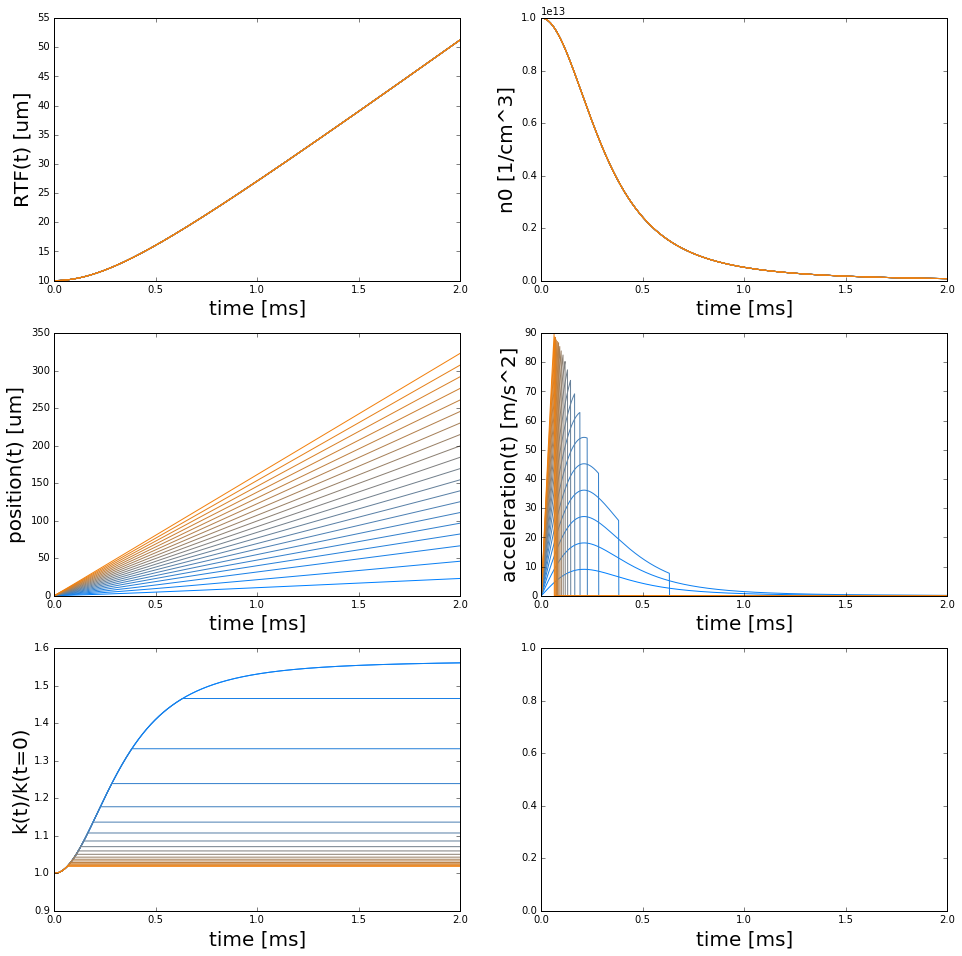

In [6]:
kf=np.zeros(Nk)
R=np.zeros(Nk)
fig=plt.figure(figsize=(16,16))
##########################################################################
# scan through multiple initial k-vectors
##########################################################################
for ki in kList:
    indk=int(ki/dk-1)
    
    r=np.zeros(Nt)
    v=np.zeros(Nt)    
    gradn=np.zeros(Nt)
    a=np.zeros(Nt)
    
    ##########################################################################
    # calculate initial conditions for this run
    ##########################################################################
    r[0]=0
    v[0]=hbar*ki/m
    gradn[0]=-2*n0t[0]*r[0]/RTFt[0]**2
    gradn[r>RTFt]=0
    a[0]=-2*g*gradn[0]/m
    
    # calculate trajectory using finite difference
    for i in range(1,Nt):
        r[i] = r[i-1] + v[i-1]*dt
        v[i] = v[i-1] + a[i-1]*dt
        
        gradn[i]=-2*n0t[i]*r[i]/RTFt[i]**2
        gradn[r>RTFt]=0
        a[i]=-2*g*gradn[i]/m

    k=m*v/hbar
    
    ##########################################################################
    # plot this trajectory
    ##########################################################################
    col=[(indk)/Nk, 0.5, 1-(indk)/Nk]
    fs=20
        
    # plot TF radius vs time
    plt.subplot(3,2,1)
    plt.plot(t*1e3,RTFt*1e6,color=col)
    plt.ylabel('RTF(t) [um]', fontsize=fs)
    
    # plot peak BEC density
    plt.subplot(3,2,2)
    plt.plot(t*1e3,n0t*1e-6,color=col)
    plt.ylabel('n0 [1/cm^3]', fontsize=fs)
    
    # plot particle position, r
    plt.subplot(3,2,3)
    plt.plot(t*1e3,r*1e6,color=col)
    plt.ylabel('position(t) [um]', fontsize=fs)
    
    # plot particle acceleration, a
    plt.subplot(3,2,4)
    plt.plot(t*1e3,a,color=col)
    plt.ylabel('acceleration(t) [m/s^2]', fontsize=fs)
    
    # plot the change in the particle momentum, k/k_{initial}, vs time.
    plt.subplot(3,2,5)
    plt.plot(t*1e3,k/ki,color=col)
    plt.ylabel('k(t)/k(t=0)', fontsize=fs)
    
    for i in range(1,7):
        plt.subplot(3,2,i)
        plt.xlim([0,t[-1]*1e3])
        plt.xlabel('time [ms]', fontsize=fs);            
    
    
    # save the assymptotic k-vector, and the ratio of the final to initial k-vectors.
    kf[indk]=k[-1]
    R[indk]=kf[indk]/ki

The above plots summarize the trajectory the particle has taken, for particles with varying initial momentum $k_i =$ 0.5 to 10 [1/um] (blue to orange).  The acceleration curves are illustrative.  Slow particles (blue) essentially stay within the BEC forever.  Fast particles (orange) eventually escape, as seen by the abrupt drop in acceleration as the particle passes the TF radius.  The larger the initial velocity, the more quickly it escapes the BEC.  It's interesting to note though that these particles also see the largest accelerations as they quickly reach the edge of the BEC and at early TOF, where/when the density gradients are the largest.  These dynamics are reflected in the ratio of the final and initial velocities.  Again, slow particles have their velocity heavily modified by the BEC, whereas fast ones are barely affected.

Next we compare the initial k-vector to the final.  The below plots are another reflection of what was already seen above.  Slow particles have their trajectories strongly modified by the BEC, fast particles are not.

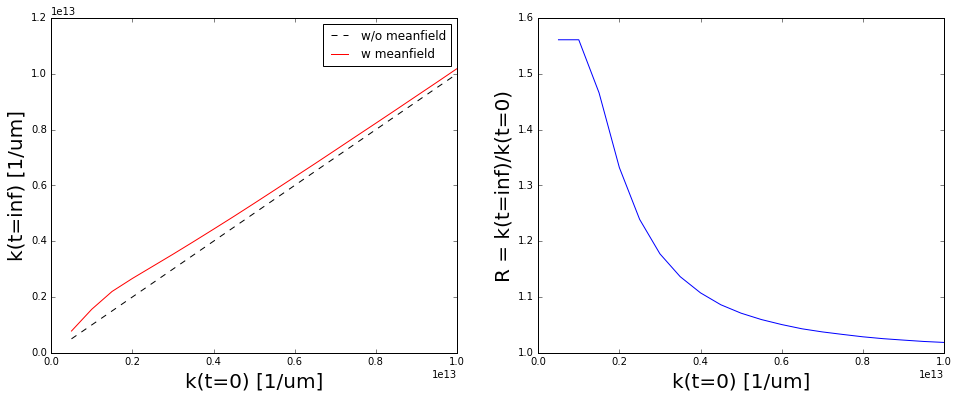

In [7]:
fig=plt.figure(figsize=(16,6))
plt.subplot(121)
plt.plot(kList*1e6,kList*1e6,'--',color='k',label='w/o meanfield')
plt.plot(kList*1e6,kf*1e6,color='r',label='w meanfield')
plt.ylabel('k(t=inf) [1/um]', fontsize=fs)
plt.xlabel('k(t=0) [1/um]', fontsize=fs)
plt.legend()
plt.subplot(122)
plt.plot(kList*1e6,R,color='b')
plt.ylabel('R = k(t=inf)/k(t=0)', fontsize=fs)
plt.xlabel('k(t=0) [1/um]', fontsize=fs)


Unfortunately, the form of the variation (change in the momentum) was not what I was hoping to see.  I was hoping to see something linear,

$$k_f=k_i+A\times k_i$$

where $A$ is some constant.  This type of transformation, $I$ $think$, uniquely maintains the the $n(k)\sim 1/k^4$ scaling behavior we expect from quantum depletion.  The calculated behavior, which clearly contains higher polynomial terms $k_f\sim k_i+A\times k_i+B\times k_i^2...$, will not.

A second point is that this calculation predicts effects on the 5-10% level (in momentum).  Roughly speaking, this will yield an effect on the $1/k^4$ tails of $(10\%)^4$, not nearly enough to account for the observed discrepancy.

In [ ]:
nk=1/kList**4
fig=plt.figure(figsize=(8,6))

plt.loglog(kList*1e-6,nk,'--',color='k',label='w/o meanfield')
plt.loglog(kf*1e-6,nk,color='r',label='w meanfield')
plt.ylabel('k(t=inf) [1/um]', fontsize=fs)
plt.xlabel('k(t=0) [1/um]', fontsize=fs)
plt.xlim([0.1,10])
plt.grid()
plt.legend()
